In [3]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

# 1. Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b, $$

$$y = \langle \mathbf{w}, \mathbf{x} \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $\mathbf{w}$, $\mathbf{x} \in \mathbb{R}^n$.

В многомерном случае формулу линейной регрессии можно переписать следующим образом:
$$ \mathbf{y} = X\mathbf{w}, $$

**Лосс:**
$$
\begin{aligned}
L(\mathbf{w}) &= \frac{1}{\ell}||\mathbf{y}_{pred} - \mathbf{y}||^2_2 = \frac{1}{\ell}||X\mathbf{w} - \mathbf{y}||^2_2 = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(\sum_{j=1}^{n} x_{ij}w_j - y_i\right)^2
\end{aligned}
$$

# Аналитическое решение

In [15]:
class MyLinearRegression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis] # ell, 1
        l, n = X.shape

        X_train = np.hstack((X, np.ones((l, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self

    def predict(self, X):
        l, n = X.shape

        X_train = np.hstack((X, np.ones((l, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def get_weights(self):
        return self.w.copy()


In [16]:
def linear_expression(x):
    return 5 * x + 6

In [21]:
objects_num = 100
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

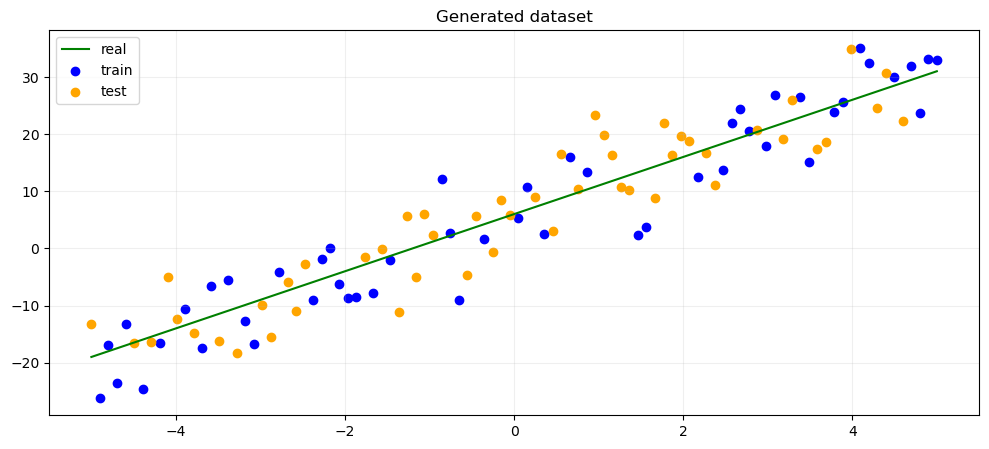

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [23]:
regressor = MyLinearRegression()
regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

array([[5.26607357],
       [5.32177746]])

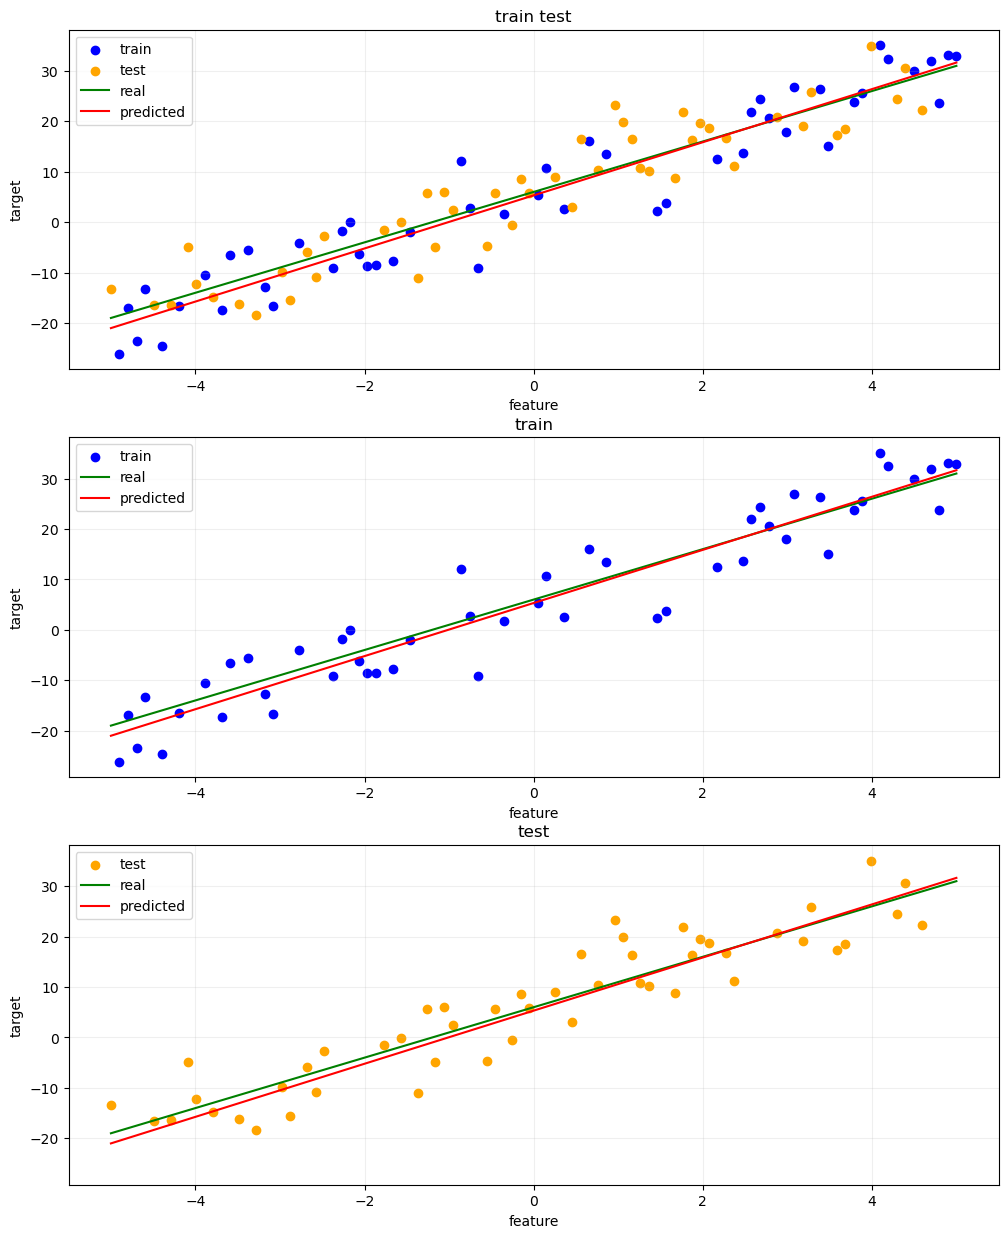

In [25]:
plt.figure(figsize=(12, 15))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(3, 1, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

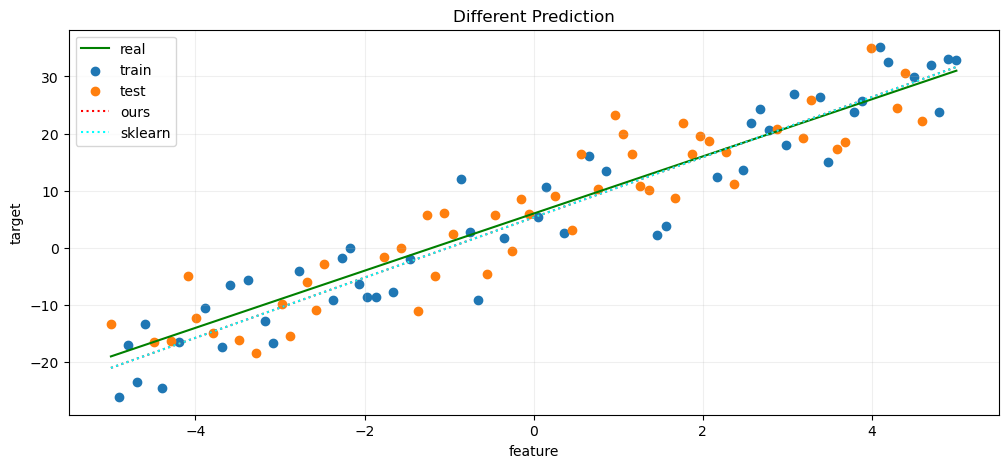

In [26]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='ours', c='r', linestyle=':')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='cyan', linestyle=':')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Train MSE:  27.22540057940845
Test MSE:  28.057630988524394


### Градиентная оптимизация

$$\mathbf{w} := \mathbf{w} - \alpha\frac{\partial{L}}{\partial{\mathbf{w}}};$$
**Предполагаемая зависимость:** $\mathbf{y} = X\mathbf{w}$, где $\mathbf{y} \in \mathbb{R}^{\ell\times 1}, X \in \mathbb{R}^{\ell\times n}, \mathbf{w} \in \mathbb{R}^{n\times 1}$


**Минимизируемая функция:**
$$
L(\mathbf{w}) = \frac{1}{\ell} ||\mathbf{y}_{pred} - \mathbf{y}||^2 = \frac{1}{\ell}||X\mathbf{w} - \mathbf{y}||^2 = \frac{1}{\ell}(X\mathbf{w} - \mathbf{y})^T(X\mathbf{w} - \mathbf{y}) = \frac{1}{\ell}(\mathbf{w}^TX^TX\mathbf{w} - 2\mathbf{y}^TX\mathbf{w} + \mathbf{y}^T\mathbf{y})
$$

**Градиент относительно $\mathbf{w}$:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = \frac{2}{\ell}(X^TX\mathbf{w} - X^T\mathbf{y}) = \frac{2}{\ell}X^T(\mathbf{y}_{pred} - \mathbf{y}) \,\, \in \mathbb{R}^{n \times 1}
$$

In [29]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, X, y, lr=0.01, max_iter=100):
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]
        l, n = X.shape
        
        X_train = np.hstack((X, np.ones((l, 1))))

        self.w = np.random.randn(n + 1, 1)

        self.losses = []

        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y, y_pred))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, \
            f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"

            self.w -= lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = (2. / X.shape[0]) * (X.T @ (y_pred - y))

        return grad

    def get_losses(self):
        return self.losses

In [30]:
regressor = MyGradientLinearRegression()

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

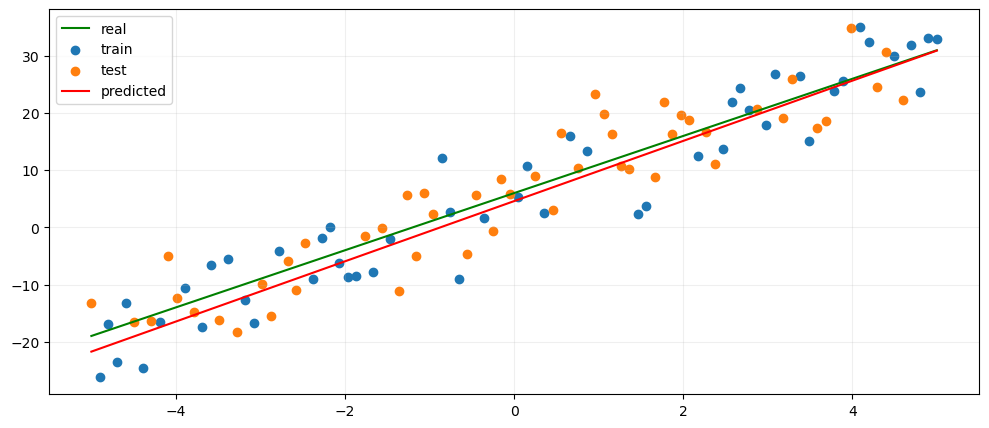

In [34]:
plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

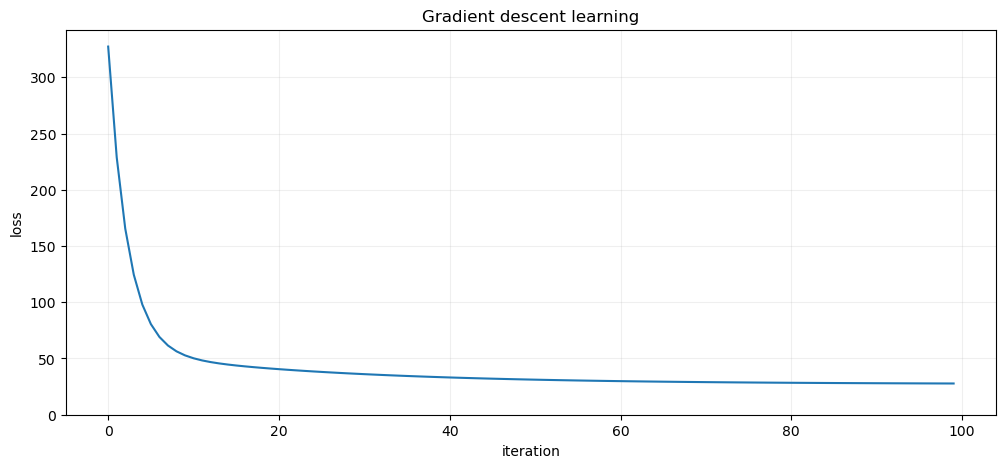

In [35]:
plt.figure(figsize=(12, 5))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

### Стохастический градиентный спуск

In [36]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        grad = 2 / self.n_sample * X[inds].T @ (y_pred[inds] - y[inds])

        return grad

In [37]:
regressor = MySGDLinearRegression()

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

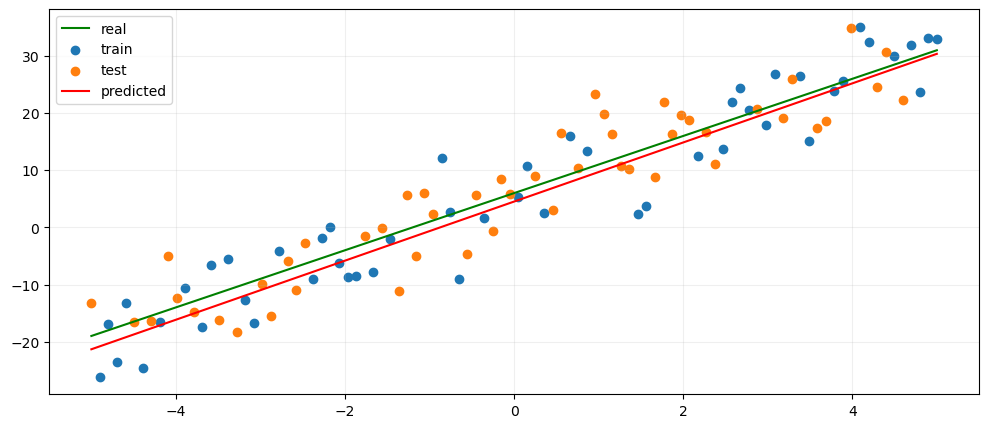

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

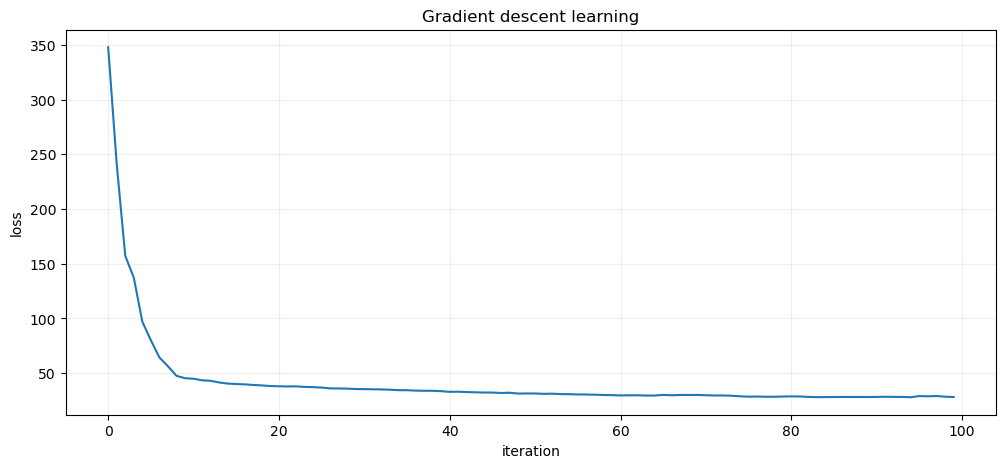

In [41]:
plt.figure(figsize=(12, 5))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

In [44]:
n_samples = [4, 8, 16]

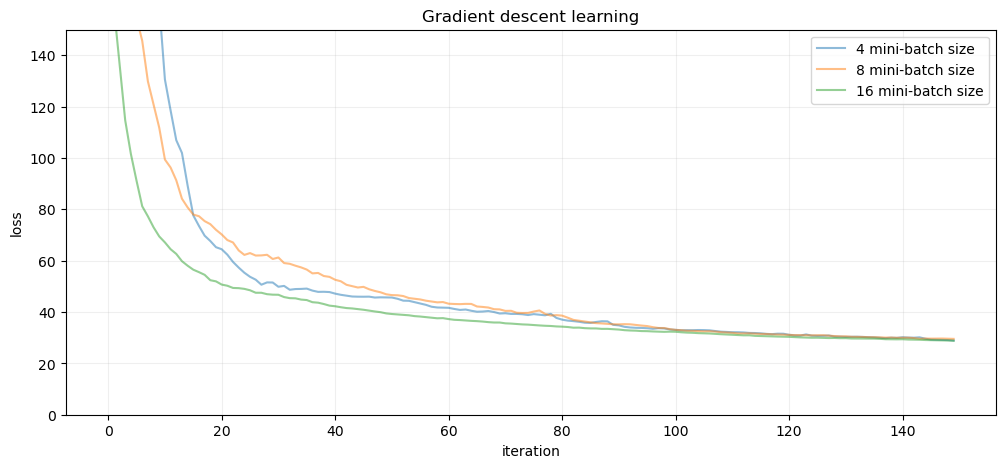

In [45]:
plt.figure(figsize=(12, 5))

for ns in n_samples:
    l = MySGDLinearRegression(n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()